In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from matplotlib.colors import ListedColormap
from matplotlib import colors
cmap = colors.LinearSegmentedColormap('red_blue_classes',
                                      {'red': [(0, 1, 1), (1, 0.7, 0.7)],
                                       'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
                                       'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

## Linear SVM reminder

Let's look at binary classification problem. Training samples are given by $\{(x_n, y_n)\}_{n=1}^N$, where $N$ — number of objects, $\boldsymbol x_n \in \mathbb{R}^d$ — feature vector of object, $y_n \in \{+1, -1\}$ — class of object.

SVM trains model for separating hyperplane:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Parameters of model — vector of weights $\boldsymbol w \in \mathbb{R}^d$ and bias $b \in \mathbb{R}$.

Training is done by solving optimisation problem:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Constraint $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ assures that objects are correctly classified by separating hyperplane. Since in practice the sample could not be linearly separable the slack variables $\xi_n$ are introduced , which weakens condition of right classification. $\| \boldsymbol w \|^2$ penalise small width of margin,  $\sum_n \xi_n$ penalise weakens of constraints.

The solution of optimisation problem is given by $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, some of the constraints become active, i.e. become a exact equality:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Objects, corresponding to active constraints called $\textbf{support vectors}$.


Hyperparameter $C$ is responsible of balancing the width of margin and errors, made by classifier. It shows the generalizing property of the separating hyperplane - big values of $C$ corresponds to less generalizing ability and can lead to overfitting, if the data is well described by linear model. To select $C$ one must do cross-validation on validation set to find the best value.

### Realisation

There are two realisations of linear SVM in sklearn : [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) and [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with *linear* kernel. They build on different libraries, with solve optimisation problem *liblinear* in first case and *libsvm* in second.

Here we will use [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with *kernel='linear'*.

We generate data samples with:
- linearly separable classes
- with well separable classes, but not linearly
- with non separable classes.

### Plotting function

In [3]:
def fit_and_plot(X, y, model, Nx=200, Ny=200):
  # Splitting the dataset and fitting on the train part
  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

  model.fit(X_train, y_train)

  # Plotting the `|margin| < 1` band
  grid_x0 = np.linspace(X[:,0].min() - 0.5, X[:,0].max() + 0.5, Nx)
  grid_x1 = np.linspace(X[:,1].min() - 0.5, X[:,1].max() + 0.5, Ny)

  xx0, xx1 = np.meshgrid(grid_x0, grid_x1)
  zz = model.decision_function(
      np.c_[xx0.ravel(), xx1.ravel()]
  ).reshape(xx0.shape)

  plt.contourf(xx0, xx1, zz, cmap=plt.cm.RdBu, alpha=.8, linestyles=['--', '-', '--'], levels=[-1, 0, 1])
  plt.contour(xx0, xx1, zz, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
  plt.pcolormesh(xx0, xx1, zz, cmap=cmap,norm=colors.Normalize(0., 1.), zorder=0)

  # Highlighting support vectors
  if hasattr(model, "named_steps"):
    sv = model[:-1].inverse_transform(
        model.named_steps['svc'].support_vectors_
    )
  else:
    sv = model.support_vectors_
  plt.scatter(*sv.T, s=180, facecolors='none', zorder=10, edgecolors='black', linewidths=0.5)

  # Plotting the data points
  plt.scatter(*X_train.T, c=y_train, cmap=cm_bright, alpha=0.3, s=36)
  plt.scatter(*X_test.T, c=y_test, cmap=cm_bright, alpha=0.8, s=36, marker='<')

  # Tweaking the plot a bit
  plt.xlim(xx0.min(), xx0.max())
  plt.ylim(xx1.min(), xx1.max())
  plt.xlabel("x0")
  plt.ylabel("x1")

### Datasets

In [4]:
datasets = []

# Linearly separable datset:
datasets.append(
    make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.5, random_state=42)
)

# Linearly inseparable:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2,
                               random_state=231, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 15 * rng.uniform(size=X.shape)
datasets.append((X, y))

# Circles:
datasets.append(make_circles(n_samples=100, noise=0.05, random_state=42))

### Example

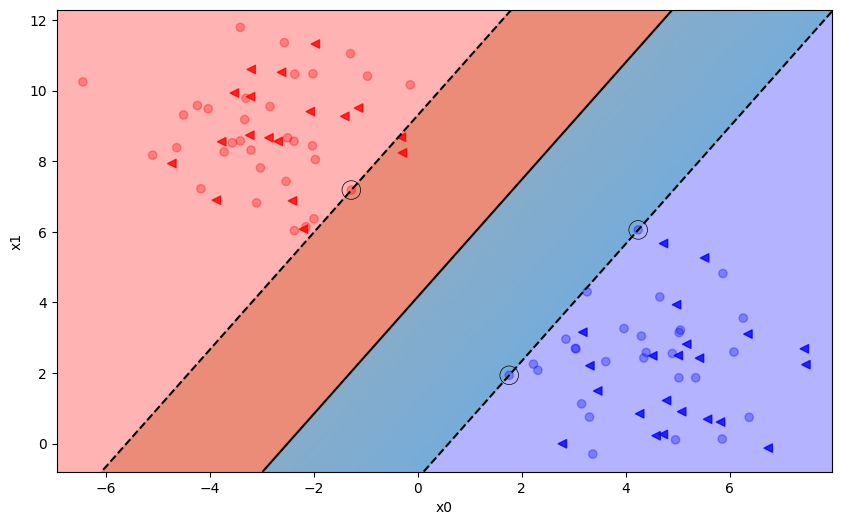

In [5]:
X, y = datasets[0] # Try datasets 1 and 2 as well

model = make_pipeline(
    StandardScaler(),
    SVC(C=100., kernel='linear') # Play around with the value of C
)

plt.figure(figsize=(10, 6))
fit_and_plot(X, y, model)

Let's add PolynomialFeatures transformer to the example above.

Note: sklearn's PolynomialFeatures transformer doesn't have an `inverse_transform` method defined, so our plotting code won't work. A small hack to fix this:

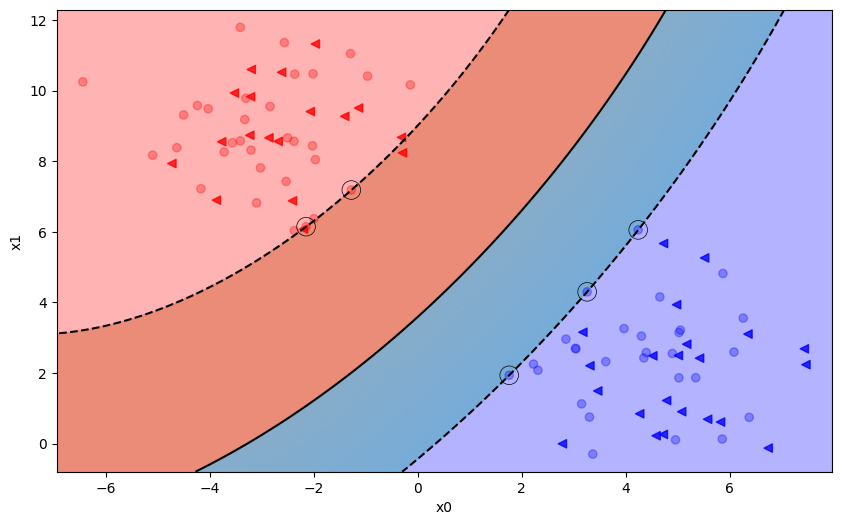

In [6]:
X, y = datasets[0]

poly = PolynomialFeatures(2, include_bias=False)
poly.inverse_transform = lambda X: X[:,:2]

model = make_pipeline(
    StandardScaler(),
    poly,
    SVC(C=1000., kernel='linear')
)

plt.figure(figsize=(10, 6))
fit_and_plot(X, y, model)

### Number of support vectors

How does the number of support vectors depend on C on different datasets?
Extract info about support vectors from SVC and plot a graph, representing Number of Support Vectors VS value of C for all 3 datasets **(2 points)**.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Generate or load your datasets and labels
datasets = [...]  # Define your datasets

# Define a range of C values to test
C_values = np.logspace(-4, 4, 50, base=10)

# Create lists to store the number of support vectors for each dataset
support_vectors_by_dataset = []

# Loop through each dataset
for dataset, labels in datasets:
    # Create an empty list to store the number of support vectors for each C value
    support_vectors_for_dataset = []

    # Loop through different C values
    for C in C_values:
        # Create an SVC model with the current C value
        svc_model = SVC(C=C, kernel='linear')
        svc_model.fit(dataset, labels)

        # Get the number of support vectors and store it
        num_support_vectors = np.sum(svc_model.n_support_)
        support_vectors_for_dataset.append(num_support_vectors)

    # Store the support vectors data for the current dataset
    support_vectors_by_dataset.append(support_vectors_for_dataset)

# Plot the results for each dataset
for dataset, support_vectors in zip(datasets, support_vectors_by_dataset):
    plt.plot(C_values, support_vectors, label=f'Dataset {dataset}')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors vs. C for Different Datasets')
plt.legend()
plt.grid(True)
plt.show()


TypeError: ignored

## Kernel SVM

![](http://i.imgur.com/bJAzRCt.png)

Linaer SVM problem, covered above, is usually called direct optimisation problem. Any direct problem has $\textbf{dual}$ problem and in some cases optimums of both problems coincide.


Dual problem for SVM is:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Vector of dual variables is being optimised $\alpha_n$. Object $x_n$ is a SV, if $\alpha_n > 0$.

The predicted label is given by:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

#### Kernel trick
Notice, that dual problem has features only as a scalar product $x^Tx'$. This observation helps us to perform kernel trick - implicitly change feature space. Instead of calculating $\phi(\boldsymbol x)$ (as we did before) we will compute scalar product $k(\boldsymbol x, \boldsymbol x')$ called $\textbf{kernel}$ and plug it insted of $x^Tx'$ above.

Try different SVM kernels and plot pictures as above, look what other parameters kernels have and how they affect results.
- polynomial: $k(x, x') = (\gamma x^Tx' + r)^d$ with different $d = 2,3,\dots$
- Gaussian RBF: $k(x, x') = \exp(-\gamma\|x - x'\|^2)$

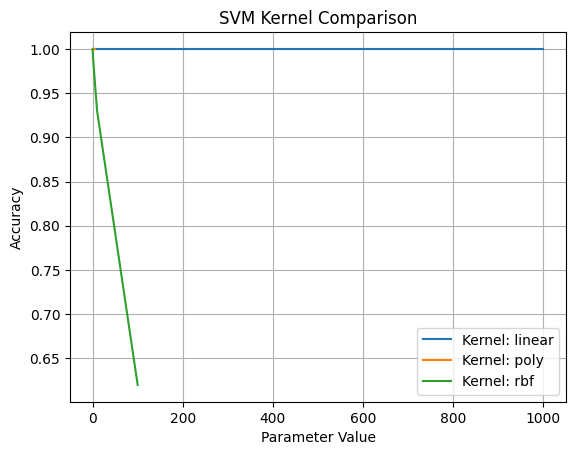

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Generate or load your datasets and labels
datasets = [...]  # Define your datasets

# Define a range of parameter values for each kernel
param_values = {
    'linear': np.logspace(-3, 3, 7),  # Vary C for the linear kernel
    'poly': np.arange(2, 7),          # Vary the degree for the polynomial kernel
    'rbf': np.logspace(-2, 2, 5)      # Vary gamma for the RBF kernel
}

# Create lists to store the results for each kernel
kernel_results = {}

# Loop through each kernel
for kernel in ['linear', 'poly', 'rbf']:
    kernel_results[kernel] = {'param_values': [], 'accuracies': []}

    # Loop through different parameter values
    for param in param_values[kernel]:
        # Create an SVC model with the current kernel and parameter
        if kernel == 'poly':
            svm_model = SVC(kernel=kernel, degree=param)
        elif kernel == 'rbf':
            svm_model = SVC(kernel=kernel, gamma=param)
        else:
            svm_model = SVC(kernel=kernel, C=param)

        # Perform cross-validation and calculate accuracy
        accuracies = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
        average_accuracy = np.mean(accuracies)

        # Store the parameter value and accuracy
        kernel_results[kernel]['param_values'].append(param)
        kernel_results[kernel]['accuracies'].append(average_accuracy)

# Plot the results for each kernel
for kernel in ['linear', 'poly', 'rbf']:
    plt.plot(kernel_results[kernel]['param_values'], kernel_results[kernel]['accuracies'], label=f'Kernel: {kernel}')

plt.xlabel('Parameter Value')
plt.ylabel('Accuracy')
plt.title('SVM Kernel Comparison')
plt.legend()
plt.grid(True)
plt.show()
